# Comp Econ Homework Set 5

Daniel Csaba, UniID: dc2730

March 2016

Task: Show downward bias of the OLS estimate in the case of an AR1 process. Use Julia to carry out the task.

Add some of the packages that will be used.

In [5]:
# Pkg.add("Distributions")
# Pkg.add("PyPlot")

In [6]:
using Distributions
using PyPlot

## AR1 Sample Path

Create a function that generates a sample path for the following AR1 process.

$X_{t+1} = \alpha X_t + \beta + \sigma W_{t+1} \qquad W_t \sim \mathcal{N}(0,1)$

Start the sample path at the mean of the stationary distribution, $X_0 = \frac{\beta}{1-\alpha}$

In [7]:
function sample_path(a::Real, b::Real, sig::Real,  n::Int64)
    """Generates a sample path of n+1 for an AR1 process"""
    
    x = Array{Float64}(n+1) # Create an empty vector for the sample path
    d = Normal(0,1) # Define the distribution for innovation
    w = rand(d, n) # Create a vector of innovations at once
    x[1] = b / (1 - a) # Start at the mean of the stationary dist.
    for i in range(1,n)
        x[i+1] = b + a * x[i] + sig * w[i]
    end
    return x
end

sample_path (generic function with 1 method)

## OLS Estimator

This function takes a time series and estimates the coefficient on the lagged variable---assuming there is also a constant.

In [8]:
function ols_est(x::Array{Float64}, n::Int64)
    """Takes a numpy array, the length and estimates the coefficient on the lagged variable"""
    
    sum_xy = sum(x[1:end-1] .* x[2:end]) # Element-by-element multiplication --> .*
    sum_xx = sum(x[1:end-1] .* x[1:end-1])
    sum_x = sum(x[1:end-1])
    sum_y = sum(x[2:end])
    return ( sum_xy - (sum_x*sum_y)/n )/( sum_xx - (sum_x*sum_x)/n )
end

ols_est (generic function with 1 method)

## Approximating the bias

The following function uses $N$ OLS estimates for a given set of parameters and sample size to aprroximate the bias of the OLS estimate given by

Bias = $\mathbb{E}\hat{\alpha} - \alpha$

In [9]:
function bias(a::Real, b::Real, sig::Real, n::Int64, N::Int64)
    """Approximate the true bias of the OLS estimate by averaging over N estimates."""
    
    alpha_hat = Array{Float64}(N)
    for i in range(1,N)
        alpha_hat[i] = ols_est(sample_path(a, b, sig, n), n)
    end
    return (mean(alpha_hat) - a)
end

bias (generic function with 1 method)

## Plot the bias for different coefficients and sample sizes

> Interesting difference relative to python: variables created in a Julia for loop are local,
so that they are not defined outside of the loop.
This is not the case in python, one can define variables on the go in a loop and acces them later after the loop ended.


First, generate the data and time it.

In [42]:
b = 1
sig = 1
N = 10000

alpha_range = [.5, .6, .7, .8, .9]
samplesize_range = collect(linspace(50, 500, 10))

# Measure time only for generating the data

A = Array{Float64}(length(alpha_range), length(samplesize_range))
@time for (i, a) in enumerate(alpha_range)
    for (j, n) in enumerate(samplesize_range)
        A[i,j] = bias(a, b, sig, Int64(n), Int64(N))
    end
end

  7.852746 seconds (12.00 M allocations: 10.998 GB, 16.70% gc time)


Less than 8 seconds for generating (10*5) = 50 bias estimates---each using 10,000 individual simulated estimates for $\hat{\alpha}$---looks like a good performance.

And lastly, plot the data.

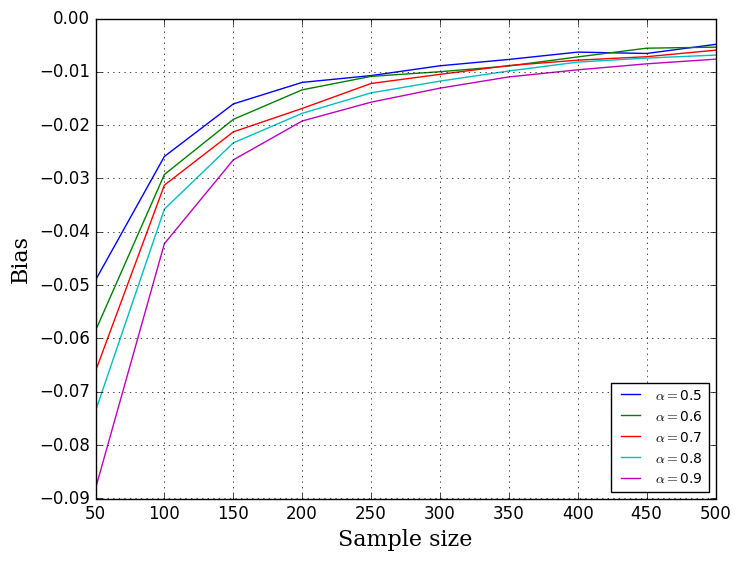

PyObject <matplotlib.legend.Legend object at 0x7f6f683e2e10>

In [43]:
fig, ax = subplots(1, 1, figsize=(8, 6))

for (i, a) in enumerate(alpha_range)
    ax[:plot](linspace(50, 500, 10), reshape(A[i,:], length(samplesize_range)), label = L"$\alpha = $" * "$a")
end
grid("on")
ax[:set_ylabel]("Bias", fontsize = 16, family = "serif")
ax[:set_xlabel]("Sample size", fontsize = 16, family = "serif")
ax[:legend](fontsize = 10, loc=4)